## Abstract
Stock market prediction is a challenging task with significant implications for investors and financial markets. This research paper explores the application of Long Short-Term Memory (LSTM) neural networks to predict the open and closing values of Amazon stocks over a ten-year period. We investigate the effectiveness of LSTM networks in capturing temporal dependencies and patterns in historical stock price data.

## Introduction
The stock market is a complex system influenced by various factors, making accurate predictions challenging. Machine learning techniques have gained popularity in predicting stock prices due to their ability to process vast amounts of data and capture intricate patterns. This study focuses on predicting Amazon stock prices using LSTM neural networks, a type of recurrent neural network (RNN) known for its effectiveness in handling sequential data.

## Methodology

### Data Collection

We collected historical daily stock price data of 12 years for Amazon till 2020. The dataset includes open and closing values, volume, high and low price. This data has been taken from Kaggle under DJIA Stock 30 Time Series Dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import math
import torch.nn as nn
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Data Loading

In [2]:
stock=pd.read_csv("amzn.csv")
stock

,Date,Open,High,Low,Close,Volume
0,1,47.47,47.85,46.25,47.58,7582127
1,2,47.48,47.73,46.69,47.25,7440914
2,3,47.16,48.20,47.11,47.65,5417258
3,4,47.97,48.58,47.32,47.87,6154285
4,5,46.55,47.10,46.40,47.08,8945056
...,...,...,...,...,...,...
3014,3015,1172.08,1174.62,1167.83,1168.36,1585054
3015,3016,1168.36,1178.32,1160.55,1176.76,2005187
3016,3017,1179.91,1187.29,1175.61,1182.26,1867208
3017,3018,1189.00,1190.10,1184.38,1186.10,1841676


In [3]:
x=stock['Date']
y1=stock['Open']
y2=stock['Close']

## Next Day Opening Price Prediction

### Training

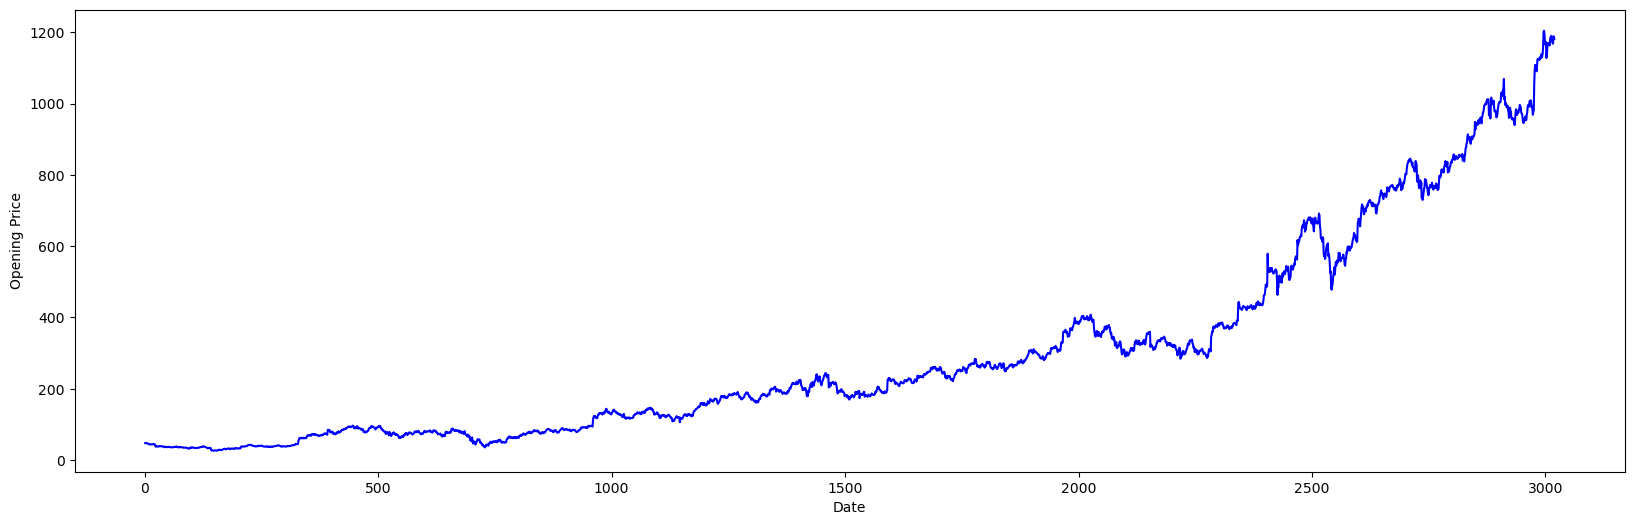

<Figure size 1000x480 with 0 Axes>

In [4]:
plt.figure(figsize=(20,6))
plt.plot(x,y1, c='b')
plt.xlabel('Date')
plt.ylabel('Opening Price')
f = plt.figure()
f.set_figwidth(10)
plt.show()

### Data Normalisation

In [5]:
open_price = stock[['Open']]
open_scaler = MinMaxScaler(feature_range=(-1, 1))
open_price['Open'] = open_scaler.fit_transform(open_price['Open'].values.reshape(-1,1))

C:\Users\SusmitPC_3\AppData\Local\Temp\ipykernel_20724\3140400763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_price['Open'] = open_scaler.fit_transform(open_price['Open'].values.reshape(-1,1))


### Data Splitting

As we are using Long Short Term Memory (LSTM) architecture, which comes under Recurrent Neural Networks (RNN), so we need to pass a sequential data as X_input for every Y_output to be predicted.
For this, we use the concept of LOOKBACK. It means the number of previous days that we take into account for predicting the value for a particular day. So we take every possible sequences of length LOOKBACK and append it to an array. Now we split this sequence data into training dataset and testing dataset in ratio 80:20.

In [6]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, open_train, x_test, open_test = split_data(open_price, lookback)

Now, we begin our model. But first of all, we need to convert our dataset in the form of numpy arrays into tensors using Pytorch.

In [7]:
x_train = torch.from_numpy(np.array(x_train)).type(torch.Tensor)
x_test = torch.from_numpy(np.array(x_test)).type(torch.Tensor)
open_train_lstm = torch.from_numpy(np.array(open_train)).type(torch.Tensor)
open_test_lstm = torch.from_numpy(np.array(open_test)).type(torch.Tensor)

Now, we define some parameters for our model. 
The dimension of input and output data is 1. We take 2 hidden layers with dimension 32. For training and testing dataset, we take number of epochs to be 150.

In [8]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 150

Finally, we create our LSTM Model.

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [10]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

Once we have created our model, we train our model using our training dataset and print the Mean Squred Error (MSE) for each epoch. As expected, the MSE decreases with number of epochs. This implies, our optimiser in the model is working perfectly.

In [11]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
loss_val=[]
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, open_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    loss_val.append(loss.item())
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.7647774815559387
Epoch  1 MSE:  0.5510662794113159
Epoch  2 MSE:  0.320406436920166
Epoch  3 MSE:  0.06965189427137375
Epoch  4 MSE:  0.19082149863243103
Epoch  5 MSE:  0.14434009790420532
Epoch  6 MSE:  0.055115483701229095
Epoch  7 MSE:  0.03570643812417984
Epoch  8 MSE:  0.05492817237973213
Epoch  9 MSE:  0.07279935479164124
Epoch  10 MSE:  0.0776025578379631
Epoch  11 MSE:  0.07190708816051483
Epoch  12 MSE:  0.06105731800198555
Epoch  13 MSE:  0.04975711926817894
Epoch  14 MSE:  0.041243474930524826
Epoch  15 MSE:  0.037110112607479095
Epoch  16 MSE:  0.03732771798968315
Epoch  17 MSE:  0.04045694321393967
Epoch  18 MSE:  0.04425065591931343
Epoch  19 MSE:  0.04667714610695839
Epoch  20 MSE:  0.04678264632821083
Epoch  21 MSE:  0.04485180974006653
Epoch  22 MSE:  0.0419386625289917
Epoch  23 MSE:  0.039198990911245346
Epoch  24 MSE:  0.037408776581287384
Epoch  25 MSE:  0.03680329769849777
Epoch  26 MSE:  0.03716878592967987
Epoch  27 MSE:  0.038048919290304184
Ep

Below is the visualisation of the relation between MSE value with number of Epochs.

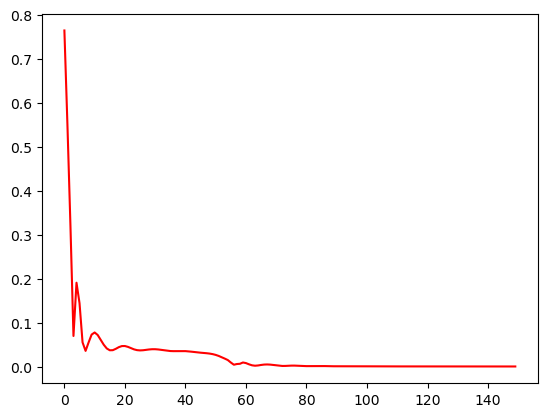

In [12]:
epoch=[i for i in range(num_epochs)]
plt.plot(epoch,loss_val,c='r')
plt.show()

Now, we visualise and calculate, how well is our prediction on the training dataset.

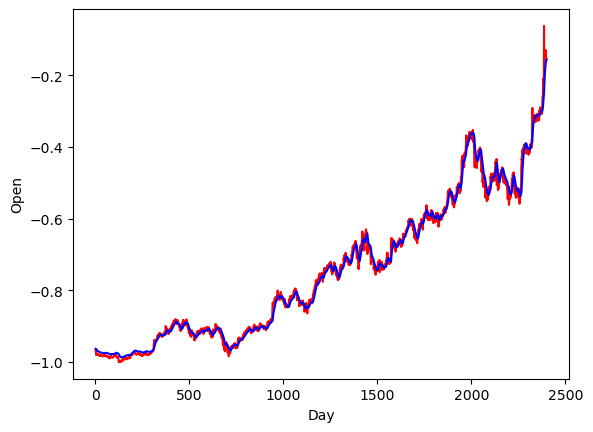

In [13]:
y_train_pred = model(x_train)
plt.plot(stock['Date'][:2399],(open_train_lstm), c='r')
plt.plot(stock['Date'][:2399], (y_train_pred).detach().numpy(), c='b')
plt.xlabel('Day')
plt.ylabel('Open')
plt.show()

In [14]:
trainScore = math.sqrt(mean_squared_error(open_train[:,0], (y_train_pred).detach().numpy()[:,0]))
print(f'Train Score: {trainScore*100} % RMSE ')

Train Score: 1.5286849700606244 % RMSE 


Thus, the Root Mean Square Error percent of our model in training dataset is 1.53%

### Testing

Now, we perform the most important part- Testing of our model on test dataset.

In [15]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
loss_val_test=[]
for t in range(num_epochs):
    y_test_pred = model(x_test)
    loss = criterion(y_test_pred, open_test_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    loss_val_test.append(loss.item())
testing_time = time.time()-start_time
print("Testing time: {}".format(testing_time))

Epoch  0 MSE:  0.1281680315732956
Epoch  1 MSE:  0.08129425346851349
Epoch  2 MSE:  0.07314121723175049
Epoch  3 MSE:  0.08306019753217697
Epoch  4 MSE:  0.03330494090914726
Epoch  5 MSE:  0.03284766525030136
Epoch  6 MSE:  0.04388337954878807
Epoch  7 MSE:  0.01161788310855627
Epoch  8 MSE:  0.04761037975549698
Epoch  9 MSE:  0.007757868617773056
Epoch  10 MSE:  0.01373734325170517
Epoch  11 MSE:  0.020871244370937347
Epoch  12 MSE:  0.015603607520461082
Epoch  13 MSE:  0.009603855200111866
Epoch  14 MSE:  0.01148057822138071
Epoch  15 MSE:  0.016018839552998543
Epoch  16 MSE:  0.011762741021811962
Epoch  17 MSE:  0.004750784020870924
Epoch  18 MSE:  0.004258454777300358
Epoch  19 MSE:  0.00651119789108634
Epoch  20 MSE:  0.00536726787686348
Epoch  21 MSE:  0.002323766937479377
Epoch  22 MSE:  0.004242870025336742
Epoch  23 MSE:  0.006815090775489807
Epoch  24 MSE:  0.003556556301191449
Epoch  25 MSE:  0.0024231288116425276
Epoch  26 MSE:  0.003772566793486476
Epoch  27 MSE:  0.003444

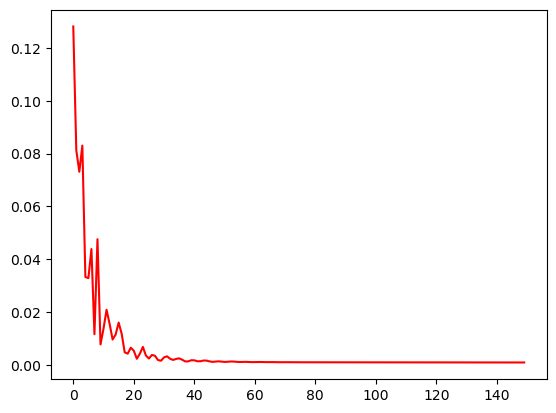

In [16]:
epoch=[i for i in range(num_epochs)]
plt.plot(epoch,loss_val_test,c='r')
plt.show()

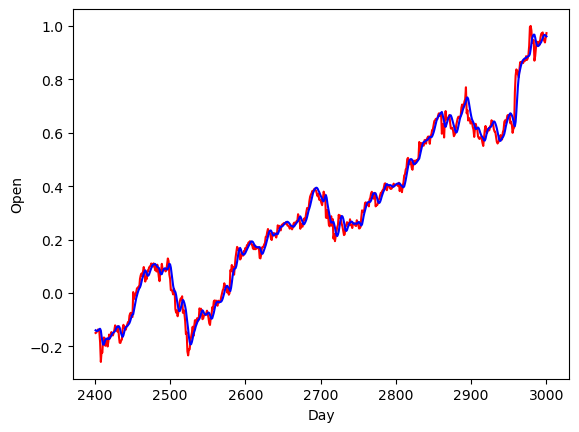

In [17]:
y_test_pred = model(x_test)
plt.plot(stock['Date'][2400:3000],(open_test_lstm), c='r')
plt.plot(stock['Date'][2400:3000], (y_test_pred).detach().numpy(), c='b')
plt.xlabel('Day')
plt.ylabel('Open')
plt.show()

In [18]:
testScore = math.sqrt(mean_squared_error(open_test[:,0], (y_test_pred).detach().numpy()[:,0]))
print(f'Test Score: {testScore*100} % RMSE ')

Test Score: 3.0214925850566177 % RMSE 


Thus, the Root Mean Square Error of our model on Testing dataset is 3.02%. Hence, the performance of our model is quite 

## Next Day Closing Price Prediction

### Training

We will do a similar set of steps in case of predicting closing price of AMZN stocks for a period of 12 years. 

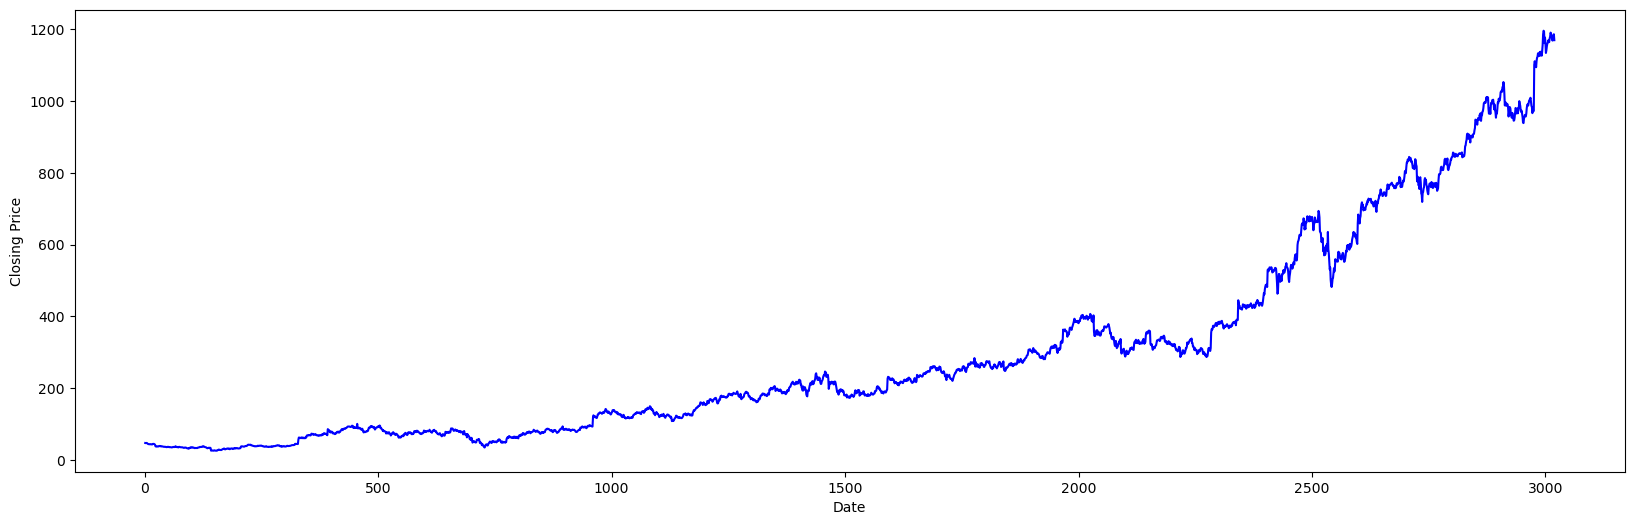

<Figure size 1000x480 with 0 Axes>

In [19]:
plt.figure(figsize=(20,6))
plt.plot(x,y2, c='b')
plt.xlabel('Date')
plt.ylabel('Closing Price')
f = plt.figure()
f.set_figwidth(10)
plt.show()

In [20]:
close_price = stock[['Close']]
close_scaler = MinMaxScaler(feature_range=(-1, 1))
close_price['Close'] = close_scaler.fit_transform(close_price['Close'].values.reshape(-1,1))

C:\Users\SusmitPC_3\AppData\Local\Temp\ipykernel_20724\3375544693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_price['Close'] = close_scaler.fit_transform(close_price['Close'].values.reshape(-1,1))


In [21]:
lookback=30
x2_train, close_train, x2_test, close_test = split_data(open_price, lookback)

In [22]:
x2_train = torch.from_numpy(np.array(x2_train)).type(torch.Tensor)
x2_test = torch.from_numpy(np.array(x2_test)).type(torch.Tensor)
close_train_lstm = torch.from_numpy(np.array(close_train)).type(torch.Tensor)
close_test_lstm = torch.from_numpy(np.array(close_test)).type(torch.Tensor)

In [23]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
loss_val_close=[]
for t in range(num_epochs):
    y_train_pred = model(x2_train)
    loss = criterion(y_train_pred, close_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    loss_val_close.append(loss.item())
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.03895028308033943
Epoch  1 MSE:  0.005333165638148785
Epoch  2 MSE:  0.03339124098420143
Epoch  3 MSE:  0.010186548344790936
Epoch  4 MSE:  0.005904796067625284
Epoch  5 MSE:  0.016338054090738297
Epoch  6 MSE:  0.01678246259689331
Epoch  7 MSE:  0.009387219324707985
Epoch  8 MSE:  0.006384963169693947
Epoch  9 MSE:  0.011342295445501804
Epoch  10 MSE:  0.01299329474568367
Epoch  11 MSE:  0.007179200649261475
Epoch  12 MSE:  0.004012695979326963
Epoch  13 MSE:  0.0067667486146092415
Epoch  14 MSE:  0.008166331797838211
Epoch  15 MSE:  0.004403274040669203
Epoch  16 MSE:  0.0012254492612555623
Epoch  17 MSE:  0.0034114893060177565
Epoch  18 MSE:  0.00438624108210206
Epoch  19 MSE:  0.0010889222612604499
Epoch  20 MSE:  0.0012338345404714346
Epoch  21 MSE:  0.003727769711986184
Epoch  22 MSE:  0.0023866777773946524
Epoch  23 MSE:  0.0008693902054801583
Epoch  24 MSE:  0.002756645204499364
Epoch  25 MSE:  0.002583250170573592
Epoch  26 MSE:  0.0008074995712377131
Epoch  2

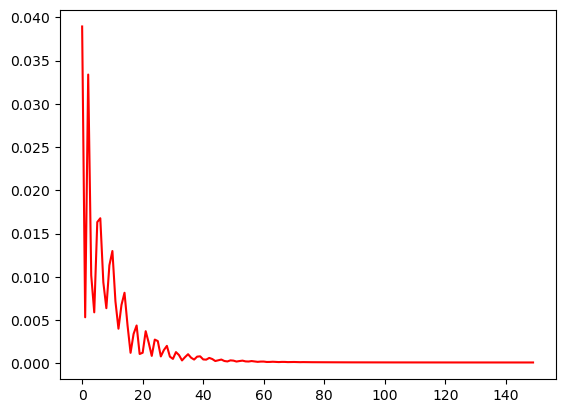

In [24]:
epoch=[i for i in range(num_epochs)]
plt.plot(epoch,loss_val_close,c='r')
plt.show()

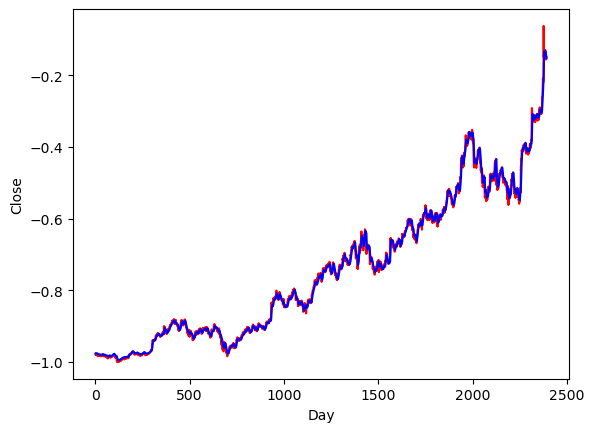

In [25]:
y_train_pred = model(x2_train)
plt.plot(stock['Date'][:2391],(close_train_lstm), c='r')
plt.plot(stock['Date'][:2391], (y_train_pred).detach().numpy(), c='b')
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

In [26]:
trainScore = math.sqrt(mean_squared_error(close_train[:,0], (y_train_pred).detach().numpy()[:,0]))
print(f'Train Score: {trainScore*100} % RMSE ')

Train Score: 1.0439612639814269 % RMSE 


Thus, we get that Root Mean Square Error of our model on training dataset is 1.04%

### Testing

In [27]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
loss_val_close_test=[]
for t in range(num_epochs):
    y_test_pred = model(x2_test)
    loss = criterion(y_test_pred, close_test_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    loss_val_close_test.append(loss.item())
training_time = time.time()-start_time
print(f"Testing time: {testing_time}")

Epoch  0 MSE:  0.0019208743469789624
Epoch  1 MSE:  0.0010527464328333735
Epoch  2 MSE:  0.0011748813558369875
Epoch  3 MSE:  0.001711831078864634
Epoch  4 MSE:  0.0011533446377143264
Epoch  5 MSE:  0.0009118386078625917
Epoch  6 MSE:  0.0013792356476187706
Epoch  7 MSE:  0.00130767363589257
Epoch  8 MSE:  0.0008966927998699248
Epoch  9 MSE:  0.0010860870825126767
Epoch  10 MSE:  0.0012584548676386476
Epoch  11 MSE:  0.0009287974680773914
Epoch  12 MSE:  0.0009105970966629684
Epoch  13 MSE:  0.0011201307643204927
Epoch  14 MSE:  0.0010089483112096786
Epoch  15 MSE:  0.0008547245524823666
Epoch  16 MSE:  0.000989423948340118
Epoch  17 MSE:  0.001027778722345829
Epoch  18 MSE:  0.0008712115813978016
Epoch  19 MSE:  0.0008884635171853006
Epoch  20 MSE:  0.0009764222777448595
Epoch  21 MSE:  0.0009004850289784372
Epoch  22 MSE:  0.0008408999419771135
Epoch  23 MSE:  0.0009175813174806535
Epoch  24 MSE:  0.0009154776926152408
Epoch  25 MSE:  0.000843545189127326
Epoch  26 MSE:  0.0008711410

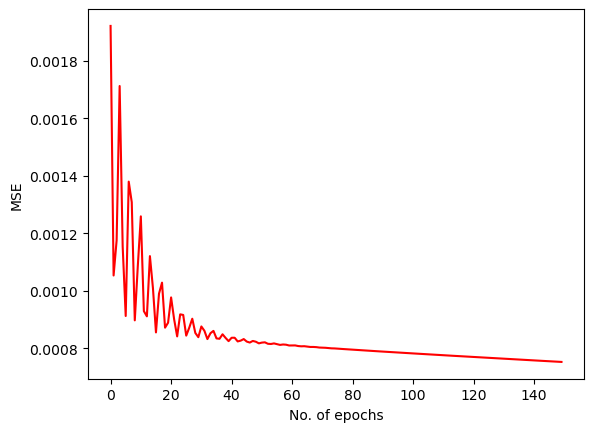

In [28]:
epoch=[i for i in range(num_epochs)]
plt.plot(epoch,loss_val_close_test,c='r')
plt.xlabel("No. of epochs")
plt.ylabel("MSE")
plt.show()

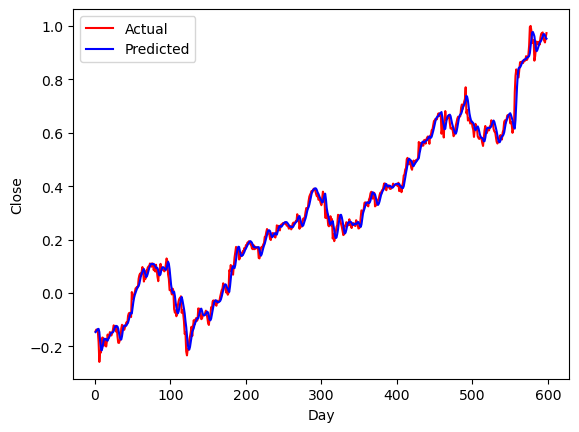

In [29]:
y_test_pred = model(x2_test)
plt.plot(stock['Date'][:598],(close_test_lstm), c='r')
plt.plot(stock['Date'][:598], (y_test_pred).detach().numpy(), c='b')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend(["Actual","Predicted"],loc="upper left")
plt.show()

In [30]:
testScore = math.sqrt(mean_squared_error(close_test[:,0], (y_test_pred).detach().numpy()[:,0]))
print(f'Test Score: {testScore*100} % RMSE ')

Test Score: 2.7413387093343946 % RMSE 


The Root Mean Square Error of our model in testing dataset is 2.74%

## Result
Our LSTM model achieved promising results in predicting Amazon stock prices. The RMSE values for Open price prediction is 1.53% in training dataset and 3.02% in testing dataset. The RMSE values for Close price prediction is 1.04% in training dataset and 2.74% in testing dataset. 

## Conclusion
This research paper explored the application of LSTM neural networks for predicting Amazon stock prices over a ten-year period. The results suggest that LSTM networks can be a valuable tool in stock market prediction. However, it is essential to consider the limitations of the model and the unpredictable nature of financial markets.